# 

# Simple test of what Campus Crowd looks like
In this notebook, we will 
1. Load the stadium dataset
2. Print key information
3. Plot crowd flow over each PAR and time

In [1]:
# import all the necessary libraries
import os
import sys
import torch

# for relative imports
os.chdir('..')
print(os.getcwd())

from campuscrowd.torch_utils import get_pyg_temporal_dataset, get_loaders

/Users/vivianwong/Documents/Research Codes/Campus-Crowd


In [2]:
class Args:
    def __init__(self):
        self.DATASET = 'Stadium'
        self.forecasting_horizon = 20
        self.train_ratio = 0.7
        self.test_ratio = 0.3
        self.val_ratio = 0.0
        self.batch_size = 32

args = Args()

## 1. Load dataset
A torch dataset can simply be loaded with the get_pyg_temporal_dataset() function. The function returns the dataset and the CMGraphs, ${G_1,...G_T}$.

The train, val, test data loaders can be obtained with the get_loaders() function

In [3]:
dataset, cmgraph = get_pyg_temporal_dataset(args.DATASET, args.forecasting_horizon)

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x1054afd90>
Number of samples / sequences:  2356
Data(x=[6, 2, 20], edge_index=[2, 10], edge_attr=[10], y=[6, 20])


In [4]:
train_loader, val_loader, test_loader = get_loaders(dataset, args.batch_size, args.train_ratio, args.val_ratio, args.test_ratio, device=torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

Number of train buckets:  1649
Number of val buckets:  0
Number of test buckets:  707


## 2. Print Info
Let's take a few steps to examine the cmgraph, dataset and dataloader objects

cmgraph.flow_df is the crowd flow table (whose path is supplied in Stadium_2023.cfg).

timestamp, num_people, and PAR_id are the only ones necessary. The other columns are just left there for completion sake. Speed is average speed obtained from individual tracking with a detector and tracker model on CCTV recordings (see my earlier paper in Algorithms). Original recordings not released due to IRB regulations.


In [ ]:
cmgraph.flow_df

,timestamp,speed,num_people,cam_name,PAR_id,frame_number,raw_frame_number
0,0.0,NaN,1.0,Tunnel A,1,0.0,0.0
1,1.0,11.823683,2.0,Tunnel A,1,1.0,29.0
2,2.0,340.117319,2.0,Tunnel A,1,2.0,58.0
3,3.0,210.030362,1.0,Tunnel A,1,3.0,87.0
4,4.0,381.040588,1.0,Tunnel A,1,4.0,116.0
...,...,...,...,...,...,...,...
14770,2471.0,119.711735,8.0,Tunnel F,6,2471.0,71659.0
14771,2472.0,73.658169,6.0,Tunnel F,6,2472.0,71688.0
14772,2473.0,79.251304,5.0,Tunnel F,6,2473.0,71717.0
14773,2474.0,106.736505,4.0,Tunnel F,6,2474.0,71746.0


cmgraph.A is the adjacency matrix that was provided in Stadium_2023.cfg. 

In [ ]:
cmgraph.A

tensor([[0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 1., 0., 0.],
        [0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 1., 0.]], dtype=torch.float64)

cmgraph.X is the node feature matrix, which was processed from cmgraph.flow_df. It is simply the timestamp and num_people columns of cmgraph.flow_df, except with some processing steps: 1) trimmed so that all PARs share the same period of time, and 2) it is normalized via the z-score method. (Details of those steps can be found in cmgraph.py -> CMGraph._get_nodal_matrix())

idea: Future work could explore whether other features like the average speed column will improve forecasting performance. 

In [ ]:
print(cmgraph.X.shape) # (num_PAR/num_nodes (N), num_features (D), num_timesteps (T))
cmgraph.X

torch.Size([6, 2, 2395])


tensor([[[-1.0354, -0.9985, -0.9985,  ..., -0.8137, -0.8507, -0.8507],
         [-1.7313, -1.7299, -1.7284,  ...,  1.7284,  1.7299,  1.7313]],

        [[-0.9985, -0.9985, -0.9985,  ..., -0.8137, -0.8137, -0.9246],
         [-1.7313, -1.7299, -1.7284,  ...,  1.7284,  1.7299,  1.7313]],

        [[-0.3702, -0.2594, -0.2224,  ..., -0.0377, -0.0377, -0.1116],
         [-1.7313, -1.7299, -1.7284,  ...,  1.7284,  1.7299,  1.7313]],

        [[-0.2594, -0.1116,  0.0363,  ..., -0.1855, -0.1485, -0.2224],
         [-1.7313, -1.7299, -1.7284,  ...,  1.7284,  1.7299,  1.7313]],

        [[-0.7028, -0.6289, -0.6659,  ..., -0.4811, -0.3702, -0.4442],
         [-1.7313, -1.7299, -1.7284,  ...,  1.7284,  1.7299,  1.7313]],

        [[-0.7028, -0.6659, -0.6289,  ..., -0.8507, -0.8507, -0.8507],
         [-1.7313, -1.7299, -1.7284,  ...,  1.7284,  1.7299,  1.7313]]])

## 3. Plot crowd flow. 
Here, we plot the 2 node features together (time vs. crowd flow)

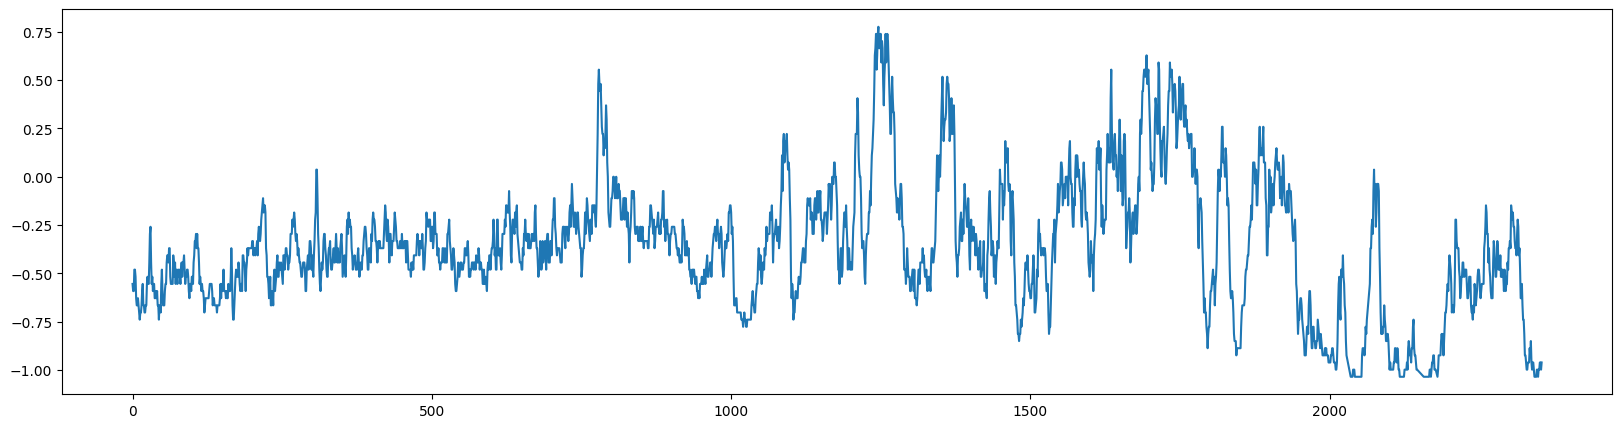

In [ ]:
import matplotlib.pyplot as plt

# Visualize normalized crowd traffic over time for region #6 (tunnel F)
plt.figure(figsize=(20,5))
PAR_id = 6
time = -1
PAR_labels = [bucket.y[PAR_id-1][0].item() for bucket in list(dataset)[:time]]
plt.plot(PAR_labels)

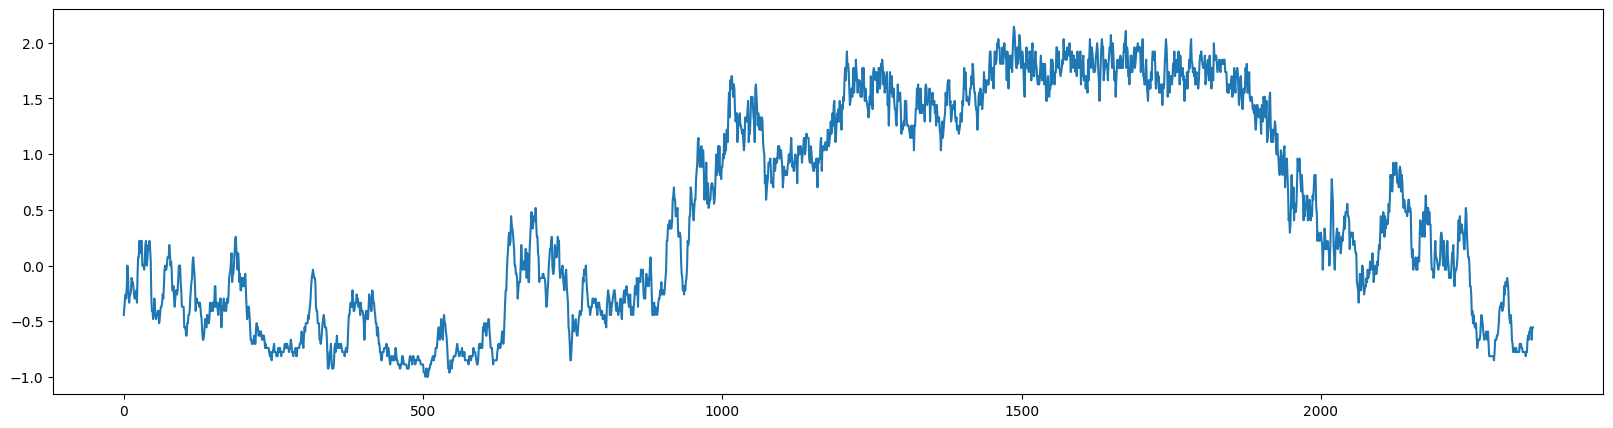

In [16]:
# Visualize normalized crowd traffic over time for region #3 (tunnel C). Note that it has a lot more people compared to tunnel F
plt.figure(figsize=(20,5))
PAR_id = 3
time = -1
PAR_labels = [bucket.y[PAR_id-1][0].item() for bucket in list(dataset)[:time]]
plt.plot(PAR_labels)